# GCL-NIDS — GNN baseline & Graph Contrastive Learning for NIDS

## Mục tiêu

Mục tiêu của notebook:
- Triển khai pipeline prototype cho NIDS dựa trên biểu diễn đồ thị: tiền xử lý → dựng đồ thị → huấn luyện GNN (GraphSAGE) → đánh giá.
- Tích hợp phần giải thích (XAI) mẫu (GNNExplainer) để minh hoạ cách trích xuất subgraph gây cảnh báo.
- **Ghi chú:** notebook hiện là baseline supervised; phần Graph Contrastive Learning (GCL) sẽ được thêm vào như bước pretraining trong phiên bản tiếp theo trong file GCL_NIDS_pipeline.ipynb


Notebook hiện tại triển khai theo pipeline:

- **(A)** Data preprocessing → **(B)** Graph construction (KNN) → **(C)** Supervised GNN training (GraphSAGE) → **(D)** XAI (GNNExplainer demonstrator).

Pipeline dự kiến phát triển:

- **Thêm** Graph Contrastive Learning (GCL) pretraining giữa (B) và (C). Sử dụng tăng cường dữ liệu cho đồ thị (edge drop, feature masking, subgraph sampling) và contrastive loss để học biểu diễn; cuối cùng fine-tune một classifier trên dữ liệu có nhãn và đánh giá chất lượng phát hiện + XAI.

## Import & setup GPU

In [2]:
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --quiet
!pip install scikit-learn matplotlib seaborn --quiet

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer

from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import NearestNeighbors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Load & Preprocess Data

### Dataset

**Datasets sử dụng trong notebook:**
- BoT-IoT (5% subset) — `./processed/bot/`
- CIC-IDS2018 (9 selected days) — `./processed/cic18/`
- UNSW — `./processed/unsw/`

**Notes for reproducibility**
1. Download data (link trong README).
2. Notebook sử dụng data dạng `.npy`.


In [4]:
# Load dữ liệu UNSW
X_train = np.load("./processed/cic18/X_train_cic18.npy")
X_test = np.load("./processed/cic18/X_test_cic18.npy")
y_train = np.load("./processed/cic18/y_train_cic18.npy")
y_test = np.load("./processed/cic18/y_test_cic18.npy")

print("Trước khi gom lớp:", np.unique(y_train, return_counts=True))

# Gom về binary: 0 = normal, 1 = attack
y_train = (y_train != 0).astype(int)
y_test = (y_test != 0).astype(int)

print("Sau khi gom lớp:", np.unique(y_train, return_counts=True))

# Chuẩn hóa feature
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Trước khi gom lớp: (array([0, 1], dtype=int64), array([4889721, 1737682], dtype=int64))
Sau khi gom lớp: (array([0, 1]), array([4889721, 1737682], dtype=int64))


## Graph Construction

Design choices and knobs (explained):
- **Node definition:** each node = a network flow (Netflow record). Alternative: host-level nodes (endpoint-centric).
- **Edge definition:** KNN on feature vectors (approximate/FAISS recommended) or explicit IP→IP edges (flow source→dest). Current notebook: **KNN with k=5** to capture local similarity in feature space.
- **Sampling options:** `N_sample` (for speed), `balance` (stratified sampling to avoid class collapse).
- **Symmetrize edges:** we add both (i→j) and (j→i) for undirected message passing.
- **Performance tradeoffs:** building full KNN on millions of points is expensive — use `faiss-cpu` or sampling.

**What to report in experiments:** nodes, edges, avg degree, build time, peak RAM.


In [5]:
def build_graph(X, y=None, k=5, log_every=5000, N_sample=100000, random_state=42):
    """
    X: numpy array (N, d)
    y: label (N,)
    k: số láng giềng
    N_sample: số mẫu tối đa để xây đồ thị (default=100k)
    """

    start = time.time()
    N = X.shape[0]
    if N > N_sample:
        rng = np.random.RandomState(random_state)
        idx = rng.choice(N, size=N_sample, replace=False)
        X = X[idx]
        y = y[idx] if y is not None else None
        print(f"[build_graph] Sampled {N_sample}/{N} samples")
    else:
        print(f"[build_graph] Using full dataset: {N} samples")

    print(f"[build_graph] Fitting NearestNeighbors (n_neighbors={k+1})...")
    nbrs = NearestNeighbors(
        n_neighbors=k+1, algorithm='auto', n_jobs=-1).fit(X)
    _, neighbors = nbrs.kneighbors(X)

    edge_index = []
    for i in range(X.shape[0]):
        if i % log_every == 0 and i > 0:
            print(
                f"  processed {i}/{X.shape[0]} (elapsed {time.time()-start:.1f}s)")
        for j in neighbors[i][1:]:
            edge_index.append([i, j])
            edge_index.append([j, i])  # symmetrize

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(
        x=torch.tensor(X, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long) if y is not None else None
    )
    print(
        f"[build_graph] Done! nodes={data.num_nodes}, edges={data.num_edges}, time={time.time()-start:.1f}s")
    return data


train_data = build_graph(X_train, y_train, k=5).to(device)
test_data = build_graph(X_test,  y_test,  k=5).to(device)

[build_graph] Sampled 100000/6627403 samples
[build_graph] Fitting NearestNeighbors (n_neighbors=6)...
  processed 5000/100000 (elapsed 45.9s)
  processed 10000/100000 (elapsed 47.2s)
  processed 15000/100000 (elapsed 47.2s)
  processed 20000/100000 (elapsed 47.3s)
  processed 25000/100000 (elapsed 47.3s)
  processed 30000/100000 (elapsed 47.3s)
  processed 35000/100000 (elapsed 47.3s)
  processed 40000/100000 (elapsed 47.4s)
  processed 45000/100000 (elapsed 47.4s)
  processed 50000/100000 (elapsed 47.5s)
  processed 55000/100000 (elapsed 47.6s)
  processed 60000/100000 (elapsed 47.6s)
  processed 65000/100000 (elapsed 47.6s)
  processed 70000/100000 (elapsed 47.6s)
  processed 75000/100000 (elapsed 47.6s)
  processed 80000/100000 (elapsed 47.8s)
  processed 85000/100000 (elapsed 47.8s)
  processed 90000/100000 (elapsed 47.8s)
  processed 95000/100000 (elapsed 47.8s)
[build_graph] Done! nodes=100000, edges=1000000, time=50.3s
[build_graph] Sampled 100000/1656851 samples
[build_graph] 

## Model: Supervised baseline (GraphSAGE)

Architecture:
- Encoder: 2-layer GraphSAGE
- Classifier: 2-layer MLP (embedding → hidden → logits)
- Loss: CrossEntropy (or BCE if binary)
- Training knobs: lr=1e-3, optimizer=Adam, epochs=..., weight decay, class weights if imbalanced

In [6]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return x


encoder = GraphSAGE(
    in_dim=X_train.shape[1], hidden_dim=256, out_dim=128).to(device)

In [1]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)


classifier = MLP(in_dim=128, hidden_dim=128, num_classes=2).to(device)

NameError: name 'torch' is not defined

## Training & Evaluation

- Train loop outputs per-epoch: loss, training time/epoch.
- Evaluation metrics:
  - Detection metrics: Precision, Recall, F1 (per-class), AUC.
  - Operational metrics: average inference latency per sample (ms), throughput (flows/sec), GPU/CPU memory usage.

**Logging recommendations (in code):**
- print time per epoch,
- measure `inference_time = timeit()` per batch and report mean ms/sample,
- keep `torch.cuda.empty_cache()` after heavy operations to reduce fragmentation (when debugging).


In [8]:
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(classifier.parameters()), lr=1e-3
)

def train_supervised(data, epochs=20):
    for epoch in range(epochs):
        encoder.train()
        classifier.train()
        optimizer.zero_grad()

        z = encoder(data.x.to(device), data.edge_index.to(device))
        logits = classifier(z)
        loss = F.cross_entropy(logits, data.y.to(device), weight=class_weights)

        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f"[Train] Epoch {epoch}, Loss={loss.item():.4f}")


def evaluate(data):
    encoder.eval()
    classifier.eval()
    with torch.no_grad():
        z = encoder(data.x.to(device), data.edge_index.to(device))
        logits = classifier(z)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = probs.argmax(axis=1)
        y_true = data.y.cpu().numpy()

    f1_w = f1_score(y_true, preds, average="weighted")
    f1_m = f1_score(y_true, preds, average="macro")
    auc = roc_auc_score(y_true, probs[:, 1])
    print(f"[Eval] F1_weighted={f1_w:.4f}, F1_macro={f1_m:.4f}, AUC={auc:.4f}")

    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(classification_report(y_true, preds))
    return f1_w, f1_m, auc

=== Supervised Training (Binary) ===
[Train] Epoch 0, Loss=0.7065
[Train] Epoch 5, Loss=0.3986
[Train] Epoch 10, Loss=0.2885
[Train] Epoch 15, Loss=0.2427
[Train] Epoch 20, Loss=0.2088
[Train] Epoch 25, Loss=0.1914
=== Evaluation on Test ===
[Eval] F1_weighted=0.9443, F1_macro=0.9295, AUC=0.9792


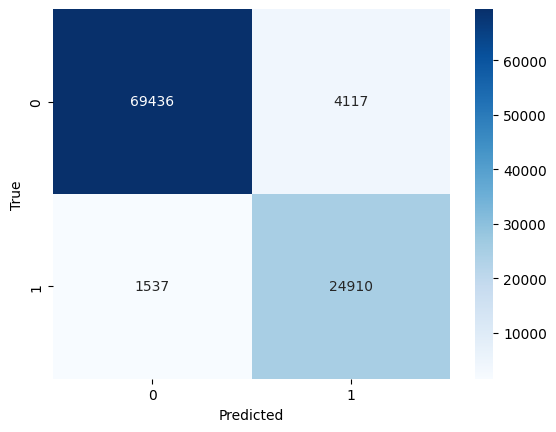

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     73553
           1       0.86      0.94      0.90     26447

    accuracy                           0.94    100000
   macro avg       0.92      0.94      0.93    100000
weighted avg       0.95      0.94      0.94    100000



(0.9442701281570376, 0.9294786952247075, 0.9792055302601528)

In [9]:
print("=== Supervised Training (Binary) ===")
train_supervised(train_data, epochs=30)

print("=== Evaluation on Test ===")
evaluate(test_data)

## Explainability (XAI)

We will provide multi-level explanations:
1. **GNNExplainer (subgraph + feature mask)** — run per-alert (node). Output: compact subgraph (highlight edges/nodes) and feature importance mask for the target node.
2. **Attention weights** (if using GAT/E-GraphSAGE) — visualize edge attention as thickness / opacity on edges.
3. **Gradient-based heatmap** (Integrated Gradients / GraphGrad-CAM) — color nodes by importance (blue→red scale).
4. **Feature importance (LIME / SHAP)** — per-flow attribute contribution (presented as small bar chart).

**How to read the figures generated here:**
- Subgraph highlight (GNNExplainer): red edges/nodes are most important; node labels show `(IP, port, count)` where available.
- Gradient heatmap: node colors map to importance score (blue low → red high).
- LIME/SHAP bar chart: top-k contributing features for the predicted label.

**Evaluation of explanations (we report):** fidelity, sparsity, and a small human-evaluation checklist (10 alerts).

In [10]:
device_cpu = torch.device("cpu")

In [11]:
# Định nghĩa full model để nối encoder + classifier
class FullModel(torch.nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)   # embedding
        out = self.classifier(z)          # logits
        return F.log_softmax(out, dim=1)  # return_type='log_probs'

In [12]:
full_model_cpu = FullModel(encoder, classifier).to(device_cpu)
test_data_cpu = test_data.to(device_cpu)

explainer = Explainer(
    model=full_model_cpu,
    algorithm=GNNExplainer(epochs=100),  # giảm epochs để tiết kiệm
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

node_id = 0
explanation = explainer(
    x=test_data_cpu.x, edge_index=test_data_cpu.edge_index, index=node_id
)

Feature mask shape: torch.Size([100000, 79])
Edge mask shape: torch.Size([1000000])


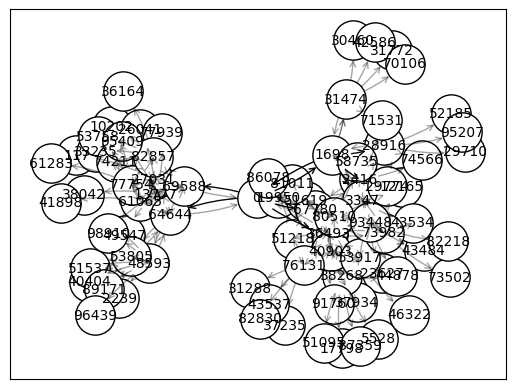

In [13]:
print("Feature mask shape:", explanation.node_mask.shape)
print("Edge mask shape:", explanation.edge_mask.shape)

# Trực quan subgraph
explanation.visualize_graph()